In [16]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler


from hn.load_data import load_data


In [17]:
# preprocessing function

def data_preprocessing(X_train, y_train, X_validation, y_validation):
    '''Data preprocessing'''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Feature selection/extraction
    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca

The number of samples: 113
The number of features: 159


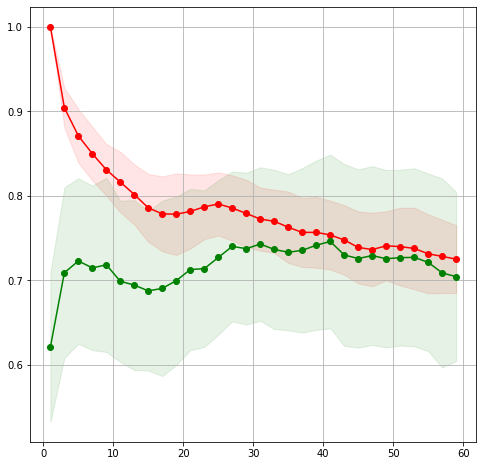

In [23]:
# AUROC of different values for K in kNN
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
k_list = list(range(1, 60, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)
            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")


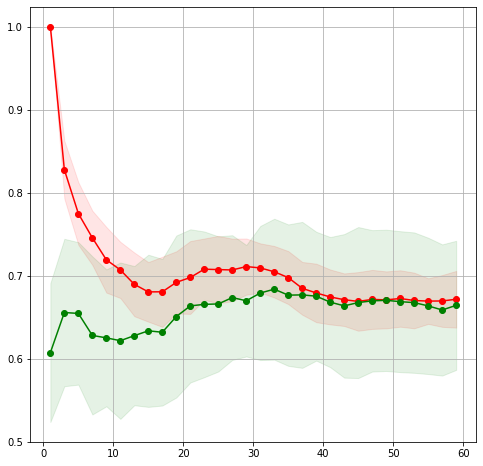

In [24]:
# Loop over the folds
k_list = list(range(1, 60, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)
            # Test the classifier on the training data and plot
       
            score_train = clf_knn.score(X_train_pca, y_train)
            score_test = clf_knn.score(X_validation_pca, y_validation)            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")


THe AUC on the replication set is 0.7954545454545454 using a 35-NN classifier


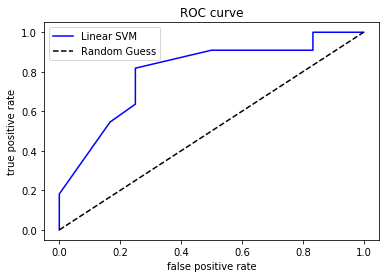

In [28]:
# Use the optimal parameters without any tuning to validate the optimal classifier
clf = neighbors.KNeighborsClassifier(n_neighbors=35)

# Fit on the entire dataset
X_train_pca, X_test_pca = data_preprocessing(split_X_train, split_y_train, split_X_test, split_y_test)

clf.fit(X_train_pca, split_y_train)

# Test the classifier on the indepedent replication data
probabilities = clf.predict_proba(X_test_pca)
scores = probabilities[:, 1]


# Get the auc
auc = metrics.roc_auc_score(split_y_test, scores)
print(f'THe AUC on the replication set is {auc} using a {clf.n_neighbors}-NN classifier')

from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(split_y_test, scores)

# roc curve
plt.plot(fpr, tpr, "b", label='Linear SVM')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()